Abstract

The data is split into 12 variables; 6 contextual variables and 6 lag variables.

### Contextual Variables

* d - Date: The date the data was collected in YYYYMMDD format.
* p - Train: An ID (unique by day d) between 1 and 55 (inclusive).
* q - Station: The ID of the station where the data was collected.
* h - Hour: The hour the data was collected in HH:00:00, 24 hour time format.
* w - Way: Whether the train is heading towards Paris (0) or away from Paris (1).
* c - Composition: The number of train units, 1 or 2.

### Lag Variables

The six lag variables represent the "Crowding Factor" (CF) of the train and follow the naming scheme of pXqY, where p stands for the train and q stands for the station. CF is a floating point number between 0 and 1 in the form of 0.XYZ. p0q0 is the CF of the current train at the current station, p3q0 is the CF of the third previous train at the current station, and p0q3 is the CF of the current train at the third previous station.

* p1q0 ∈ [0,1]: The CF of the previous train p-1 at the same station q.
* p2q0 ∈ [0,1]: The CF of the previous train p-2 at the same station q.
* p3q0 ∈ [0,1]: The CF of the previous train p-3 at the same station q.
* p0q1 ∈ [0,1]: The CF of the same train p at the previous station q-1.
* p0q2 ∈ [0,1]: The CF of the same train p at the previous station q-2.
* p0q3 ∈ [0,1]: The CF of the same train p at the previous station q-3.

**It is possible for the lag variables to be NA, meaning that there is no CF data for that particular dates, hour, and train.**

## Importing and Verifying Data

In [1]:
import pandas as pd
import seaborn as sns
from pathlib import Path as path
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
Xtrain = pd.read_csv(path('data/Xtrain.csv'))
Ytrain = pd.read_csv(path('data/Ytrain.csv'))
Xtest = pd.read_csv(path('data/Xtest.csv'))
Ysample = pd.read_csv(path('data/Ysample.csv'))

print('X Training Set', Xtrain.shape)
print('Y Training Set', Ytrain.shape)
print('X Testing Set ', Xtest.shape)
print('Y Sample Set  ', Ysample.shape)

X Training Set (31119, 12)
Y Training Set (31119, 2)
X Testing Set  (13752, 12)
Y Sample Set   (13752, 2)


## Combining Xtrain and Ytrain into TrainData

In [3]:
Ytrain = Ytrain.loc[:, ~Ytrain.columns.str.contains('^Unnamed')]
TrainData = Xtrain
TrainData = TrainData.merge(Ytrain, left_index= True, right_index= True)

print(TrainData.info(), "\n\n\n")
TrainData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         31119 non-null  object 
 1   train        31119 non-null  int64  
 2   way          31119 non-null  int64  
 3   station      31119 non-null  object 
 4   hour         27915 non-null  object 
 5   composition  31119 non-null  int64  
 6   p1q0         29067 non-null  float64
 7   p2q0         26974 non-null  float64
 8   p3q0         24935 non-null  float64
 9   p0q1         27917 non-null  float64
 10  p0q2         24720 non-null  float64
 11  p0q3         21527 non-null  float64
 12  p0q0         31119 non-null  float64
dtypes: float64(7), int64(3), object(3)
memory usage: 3.1+ MB
None 





,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
0,2019-01-07,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.201,0.138,0.091,0.216
1,2019-01-08,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.204,0.152,0.106,0.216
2,2019-01-10,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.153,0.111,0.227
3,2019-01-11,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.152,0.108,0.229
4,2019-01-14,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.210,0.147,0.096,0.225


# Data Cleaning: Analysis

## Missing Values

#### There are four types of missing values:

#### 1) Rows that contain no data in all rows

#### 2) Rows that are missing data in the *hour* column

#### 3) Rows that are missing data in the *pXq0*

#### 4) Rows that are missing data in the *p0qX*

#### The following is the total amount of missing values in TrainData

In [4]:
TrainData.isna().sum()

date              0
train             0
way               0
station           0
hour           3204
composition       0
p1q0           2052
p2q0           4145
p3q0           6184
p0q1           3202
p0q2           6399
p0q3           9592
p0q0              0
dtype: int64

#### There are 4 train stations that contain missing values in all p & q data:

In [5]:
temp = TrainData[TrainData['p1q0'].isna() & TrainData['p2q0'].isna() & TrainData['p3q0'].isna() & TrainData['p0q1'].isna() & TrainData['p0q2'].isna() & TrainData['p0q3'].isna()]
print(temp['station'].unique())

['AX' 'BG' 'AZ' 'AR']


#### Stations AR and AX have some data in the *pXq0* columns, but contain no hour data

#### Station AR:

In [6]:
temp = TrainData.loc[TrainData['station']=='AR']
print(temp['hour'].unique())
temp

[nan]


,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
21414,2019-01-07,45,0,AR,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.021
21415,2019-01-08,45,0,AR,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.020
21416,2019-01-10,45,0,AR,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.017
21417,2019-01-11,45,0,AR,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.022
21418,2019-01-14,45,0,AR,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25522,2019-05-13,50,0,AR,NaN,2,0.04400,0.0410,0.0290,NaN,NaN,NaN,0.021
25523,2019-05-14,50,0,AR,NaN,2,0.04000,0.0480,0.0300,NaN,NaN,NaN,0.014
25524,2019-05-20,50,0,AR,NaN,2,0.04100,0.0460,0.0240,NaN,NaN,NaN,0.022
25525,2019-03-21,50,0,AR,NaN,2,0.04300,0.0450,0.0260,NaN,NaN,NaN,0.024


#### Station AX:

In [7]:
temp = TrainData.loc[TrainData['station']=='AX']
temp['hour'].unique()
temp

,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
406,2019-01-07,1,0,AX,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.045
407,2019-01-08,1,0,AX,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.044
408,2019-01-10,1,0,AX,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.061
409,2019-01-11,1,0,AX,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.042
410,2019-01-14,1,0,AX,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.043
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30938,2019-05-13,9,0,AX,NaN,2,0.0840,0.110822,0.0970,NaN,NaN,NaN,0.080
30939,2019-05-14,9,0,AX,NaN,2,0.0940,0.100000,0.1190,NaN,NaN,NaN,0.089
30940,2019-05-15,9,0,AX,NaN,2,0.0910,0.085000,0.1060,NaN,NaN,NaN,0.099
30941,2019-03-21,9,0,AX,NaN,2,0.1070,0.107000,0.0950,NaN,NaN,NaN,0.074


#### Stations AZ and BG have a mix of rows that contain useful information and rows that contain no p & q data

#### Station AZ: 

In [8]:
temp = TrainData.loc[TrainData['station']=='AZ']
print(temp['hour'].unique())
temp = temp[temp['hour'].isna() == False]
temp

[nan '06:00:00' '07:00:00' '08:00:00' '09:00:00']


,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
21532,2019-01-07,45,0,AZ,06:00:00,2,0.048,NaN,NaN,0.075,0.131,0.186,0.225
21533,2019-01-08,45,0,AZ,06:00:00,2,0.068,NaN,NaN,0.084,0.140,0.185,0.219
21534,2019-01-10,45,0,AZ,06:00:00,2,0.061,NaN,NaN,0.088,0.136,0.183,0.221
21535,2019-01-11,45,0,AZ,06:00:00,2,0.049,NaN,NaN,0.098,0.151,0.197,0.223
21536,2019-01-14,45,0,AZ,06:00:00,2,0.061,NaN,NaN,0.102,0.158,0.211,0.253
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28534,2019-05-16,55,0,AZ,09:00:00,2,0.159,0.5870,0.37476,0.205,0.256,0.294,0.397
28535,2019-05-20,55,0,AZ,09:00:00,2,0.126,0.0990,0.40200,0.234,0.294,0.330,0.357
28536,2019-04-17,55,0,AZ,09:00:00,2,0.102,0.1036,0.35170,0.184,0.226,0.270,0.316
28537,2019-03-21,55,0,AZ,09:00:00,2,0.144,0.0670,0.42600,0.215,0.265,0.315,0.355


#### Station BG:

In [9]:
temp = TrainData.loc[TrainData['station']=='BG']
print(temp['hour'].unique())
temp = temp[temp['hour'].isna() == False]
temp

[nan '06:00:00' '07:00:00' '08:00:00']


,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
13236,2019-01-07,29,0,BG,06:00:00,2,0.01500,NaN,NaN,NaN,NaN,NaN,0.068
13237,2019-01-08,29,0,BG,06:00:00,2,0.01700,NaN,NaN,NaN,NaN,NaN,0.053
13238,2019-01-09,29,0,BG,06:00:00,2,0.01665,NaN,NaN,NaN,NaN,NaN,0.052
13239,2019-01-10,29,0,BG,06:00:00,2,0.01000,NaN,NaN,NaN,NaN,NaN,0.059
13240,2019-01-11,29,0,BG,06:00:00,2,0.01665,NaN,NaN,NaN,NaN,NaN,0.040
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17082,2019-05-09,33,0,BG,08:00:00,2,0.04780,0.0510,0.147,NaN,NaN,NaN,0.081
17083,2019-05-10,33,0,BG,08:00:00,2,0.05300,0.0500,0.121,NaN,NaN,NaN,0.088
17084,2019-05-15,33,0,BG,08:00:00,2,0.03400,0.0497,0.126,NaN,NaN,NaN,0.083
17085,2019-05-20,33,0,BG,08:00:00,2,0.05900,0.0540,0.146,NaN,NaN,NaN,0.089


## Redundant Values

#### There are two types of redundant values:

#### 1) The "Way" variable

#### 2) The "Composition" variable

#### Way:

In [10]:
numToParis = 0
numFromParis = 0

for i in TrainData["way"]:
    if i == 0:
        numToParis += 1
    else:
        numFromParis += 1

print("Number of trains to Paris:   " + str(numToParis))
print("Number of trains from Paris: " + str(numFromParis))
print("% of trains with going to Paris: " + str(round((numToParis / (numToParis + numFromParis)), 4) * 100))

Number of trains to Paris:   31119
Number of trains from Paris: 0
% of trains with going to Paris: 100.0


#### Composition:

In [11]:
numOfCompOne = 0
numOfCompTwo = 0

for i in TrainData["composition"]:
    if i == 1:
        numOfCompOne += 1
    else:
        numOfCompTwo += 1

print("Number of trains with one train unit:  " + str(numOfCompOne))
print("Number of trains with two train units: " + str(numOfCompTwo))
print("% of trains with one train unit: " + str(round((numOfCompOne / (numOfCompOne + numOfCompTwo)), 4) * 100))

Number of trains with one train unit:  11
Number of trains with two train units: 31108
% of trains with one train unit: 0.04


# Data Cleaning: Cleaning

#### "Way" and "Composition" can be dropped

In [12]:
CleanedTrainData = TrainData.copy()

CleanedTrainData = CleanedTrainData.drop('way', axis=1)
CleanedTrainData = CleanedTrainData.drop('composition', axis=1)

#### Decided to drop all rows that:

#### 1) Contain no *hour* data

#### 2) Contain no data in *all P & Q columns *

In [13]:
CleanedTrainData = CleanedTrainData[CleanedTrainData['hour'].isna() == False]
CleanedTrainData = CleanedTrainData[CleanedTrainData['station'] != 'AR']
CleanedTrainData = CleanedTrainData[CleanedTrainData['station'] != 'AZ']

#### Still need to handle the remaining missing data in each P & Q column

In [14]:
hours = list(CleanedTrainData['hour'].unique())

for hour in hours:
    temp = CleanedTrainData[CleanedTrainData['hour'] == hour]
    print(f"Hour: {hour}\n{temp[['p1q0','p2q0','p3q0','p0q1','p0q2','p0q3']].isna().sum()}")

Hour: 06:00:00
p1q0    1761
p2q0    3252
p3q0    4075
p0q1     110
p0q2     917
p0q3    1601
dtype: int64
Hour: 07:00:00
p1q0       0
p2q0     312
p3q0    1243
p0q1     115
p0q2    1237
p0q3    2406
dtype: int64
Hour: 08:00:00
p1q0       0
p2q0       0
p3q0       0
p0q1      58
p0q2    1164
p0q3    2316
dtype: int64
Hour: 09:00:00
p1q0      0
p2q0      0
p3q0      0
p0q1      0
p0q2    162
p0q3    350
dtype: int64
Hour: 11:00:00
p1q0    0
p2q0    0
p3q0    0
p0q1    0
p0q2    0
p0q3    0
dtype: int64


## Cleaning Missing P Values

#### 1) Rows that have no P data have made 0

#### 2) Rows that have missing P2 & P3 data have made 0

#### 3) Rows that have missing P3 data have been made (Larger P - ( Larger P - Smaller P))

In [15]:
CleanedTrainData.loc[(CleanedTrainData['p1q0'].isna()) & (CleanedTrainData['p2q0'].isna()) & (CleanedTrainData['p3q0'].isna()), ['p1q0','p2q0','p3q0']] = 0
CleanedTrainData.loc[(CleanedTrainData['p1q0'].isna() == False) & (CleanedTrainData['p2q0'].isna()) & (CleanedTrainData['p3q0'].isna()), ['p2q0','p3q0']] = 0
for i, row in CleanedTrainData.iterrows():
    if math.isnan(row['p3q0']):
        if row['p1q0'] > row['p2q0']:
            diff = row['p1q0'] - (row['p1q0'] - row['p2q0'])
        else:
            diff = row['p2q0'] - (row['p2q0'] - row['p1q0'])
        CleanedTrainData.at[i,'p3q0'] = diff
        

## Cleaning Missing Q Values

#### 1) Rows that have no Q data have made 0

#### 2) Rows that have missing Q2 & Q3 data have made 0

#### 3) Rows that have missing Q3 data have been made (Larger Q - ( Larger Q - Smaller Q))

In [16]:
CleanedTrainData.loc[(CleanedTrainData['p0q1'].isna()) & (CleanedTrainData['p0q2'].isna()) & (CleanedTrainData['p0q3'].isna()), ['p0q1','p0q2','p0q3']] = 0
CleanedTrainData.loc[(CleanedTrainData['p0q1'].isna() == False) & (CleanedTrainData['p0q2'].isna()) & (CleanedTrainData['p0q3'].isna()), ['p0q2','p0q3']] = 0
for i, row in CleanedTrainData.iterrows():
    if math.isnan(row['p0q3']):
        if row['p0q1'] > row['p0q2']:
            diff = row['p0q1'] - (row['p0q1'] - row['p0q2'])
        else:
            diff = row['p0q2'] - (row['p0q2'] - row['p0q1'])
        CleanedTrainData.at[i,'p0q3'] = diff

In [17]:
CleanedTrainData.isna().sum()

date       0
train      0
station    0
hour       0
p1q0       0
p2q0       0
p3q0       0
p0q1       0
p0q2       0
p0q3       0
p0q0       0
dtype: int64

# Exploratory Data Analysis

#### Take the given date and determine what day of the week and month it relates to

In [18]:
TrainData_Date = CleanedTrainData.copy()

# convert Time to Datetime
TrainData_Date['date'] = pd.to_datetime(TrainData_Date['date'], format='%Y/%m/%d')

# Add new column for weekday
weekday = TrainData_Date['date'].dt.day_name()
month = TrainData_Date['date'].dt.month_name()

TrainData_Date.insert(1,'weekday', weekday)
TrainData_Date.insert(2,'month', month)

TrainData_Date

,date,weekday,month,train,station,hour,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
0,2019-01-07,Monday,January,1,AD,06:00:00,0.000,0.00000,0.000000,0.201,0.138,0.091,0.216
1,2019-01-08,Tuesday,January,1,AD,06:00:00,0.000,0.00000,0.000000,0.204,0.152,0.106,0.216
2,2019-01-10,Thursday,January,1,AD,06:00:00,0.000,0.00000,0.000000,0.213,0.153,0.111,0.227
3,2019-01-11,Friday,January,1,AD,06:00:00,0.000,0.00000,0.000000,0.213,0.152,0.108,0.229
4,2019-01-14,Monday,January,1,AD,06:00:00,0.000,0.00000,0.000000,0.210,0.147,0.096,0.225
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31114,2019-05-13,Monday,May,9,BE,08:00:00,0.152,0.18860,0.157000,0.080,0.100,0.080,0.111
31115,2019-05-14,Tuesday,May,9,BE,08:00:00,0.153,0.18040,0.191000,0.089,0.121,0.089,0.143
31116,2019-05-15,Wednesday,May,9,BE,08:00:00,0.166,0.14900,0.168000,0.099,0.129,0.099,0.139
31117,2019-03-21,Thursday,March,9,BE,08:00:00,0.182,0.19300,0.162000,0.074,0.101,0.074,0.117


## Date and Time Analysis

#### It must be noted that data given for the test set only contains weekdays in the first five months of 2019

In [19]:
print('Hours:',TrainData_Date['hour'].unique())

Hours: ['06:00:00' '07:00:00' '08:00:00' '09:00:00' '11:00:00']


In [20]:
plt.rcParams['figure.figsize'] = [30, 15]

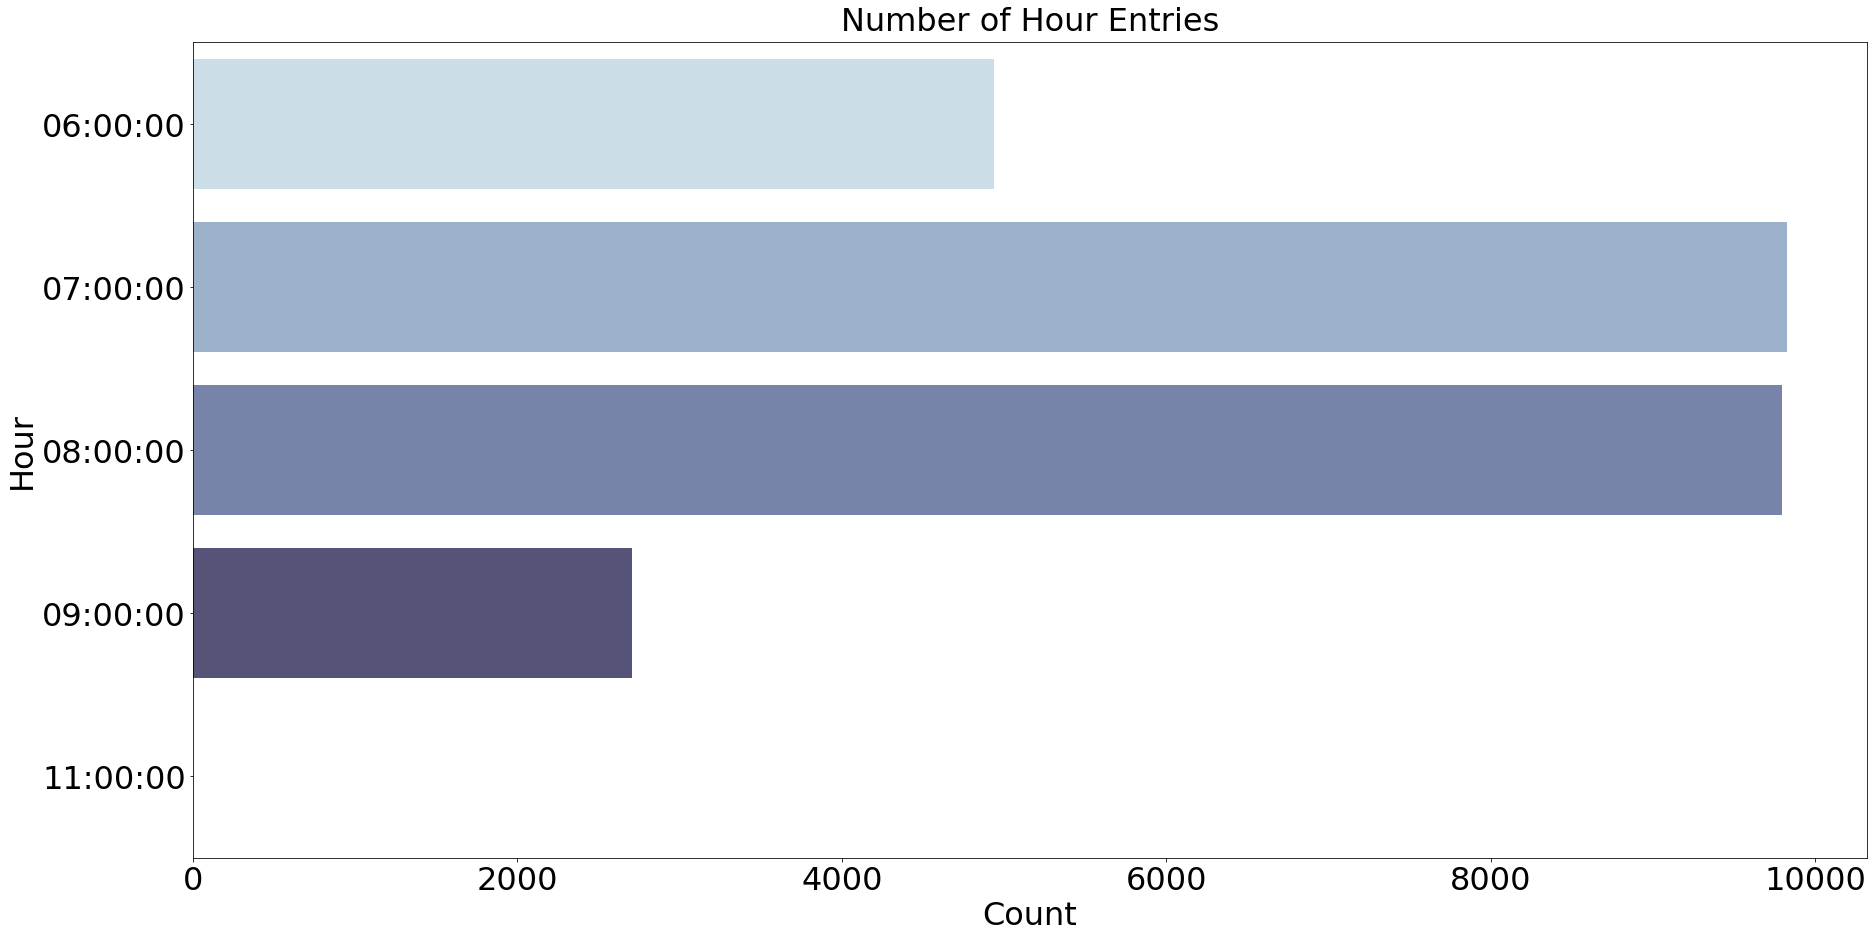

hour
06:00:00    4936
07:00:00    9827
08:00:00    9794
09:00:00    2707
11:00:00       2
dtype: int64

In [21]:
sns.countplot(y=TrainData_Date['hour'], palette='ch:s=.25,rot=-.25').set_title('Number of Hour Entries', fontdict={'fontsize':32}, pad=12)

plt.xticks(size=32)
plt.yticks(size=32)

plt.xlabel('Count', fontsize=32)
plt.ylabel('Hour', fontsize=32)

plt.show()

TrainData_Date.groupby('hour').size()

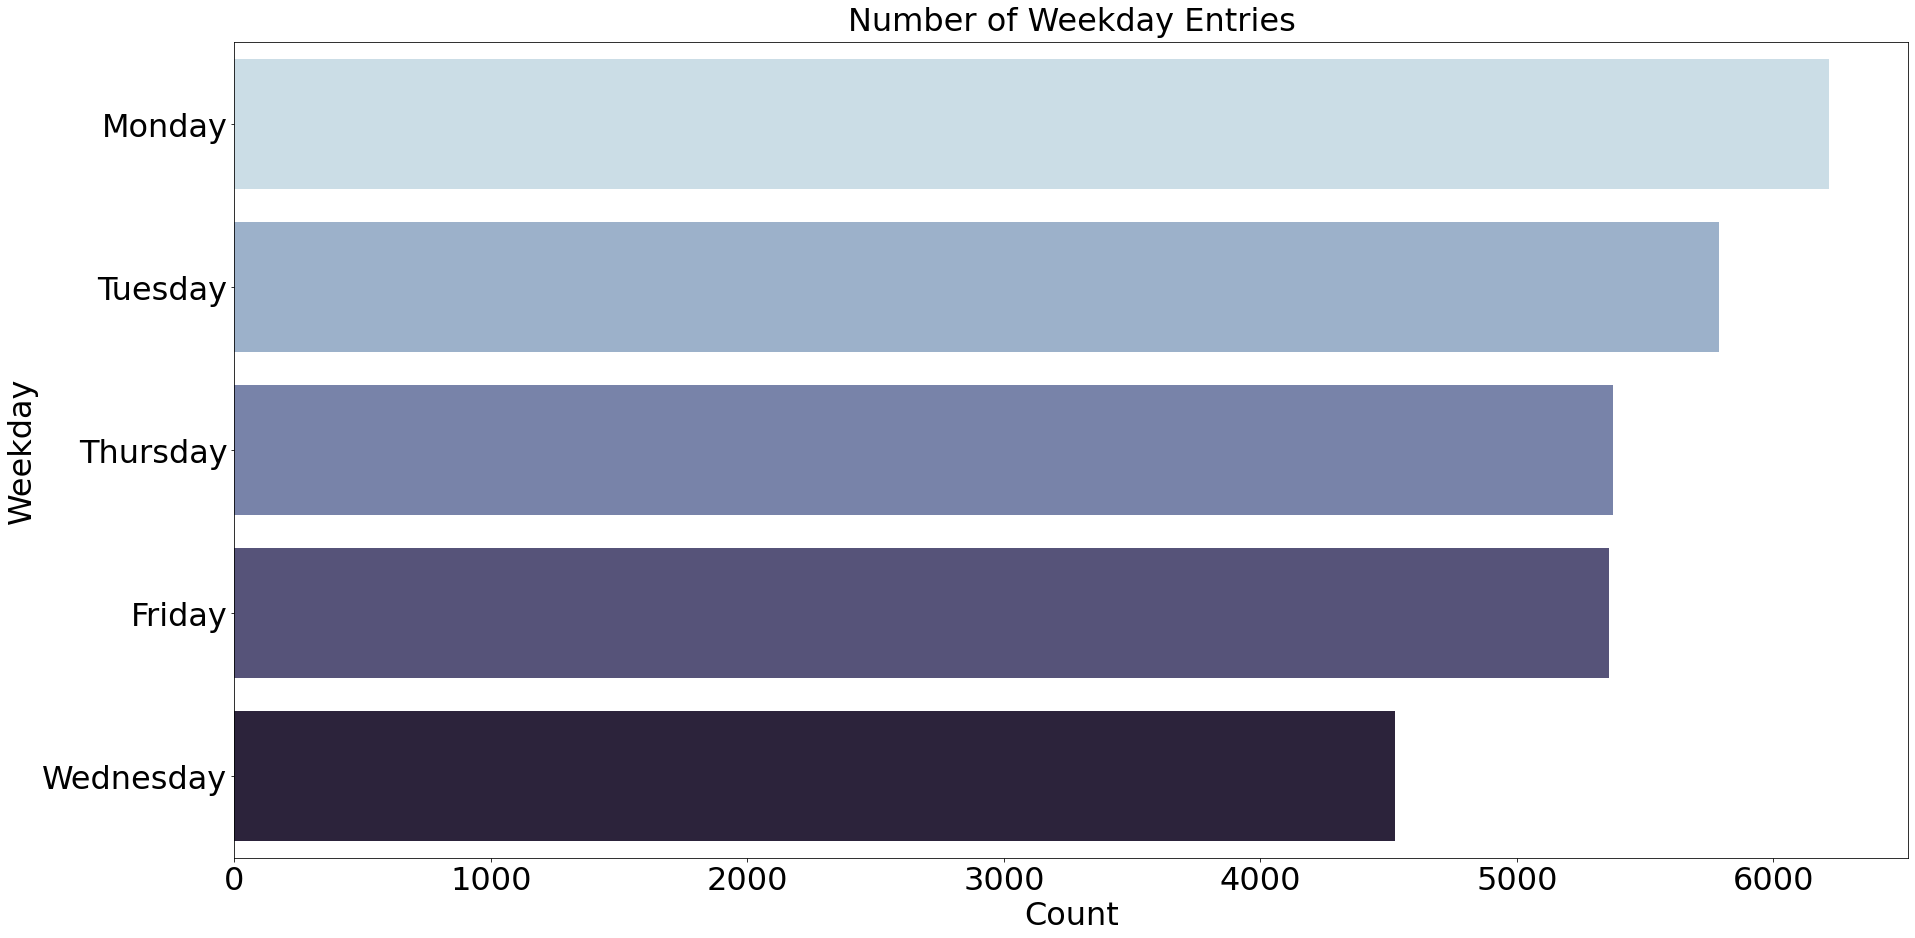

weekday
Friday       5359
Monday       6216
Thursday     5375
Tuesday      5790
Wednesday    4526
dtype: int64

In [22]:
sns.countplot(y=TrainData_Date['weekday'], palette='ch:s=.25,rot=-.25').set_title('Number of Weekday Entries', fontdict={'fontsize':32}, pad=12)

plt.xticks(size=32)
plt.yticks(size=32)

plt.xlabel('Count', fontsize=32)
plt.ylabel('Weekday', fontsize=32)

plt.show()

TrainData_Date.groupby('weekday').size()

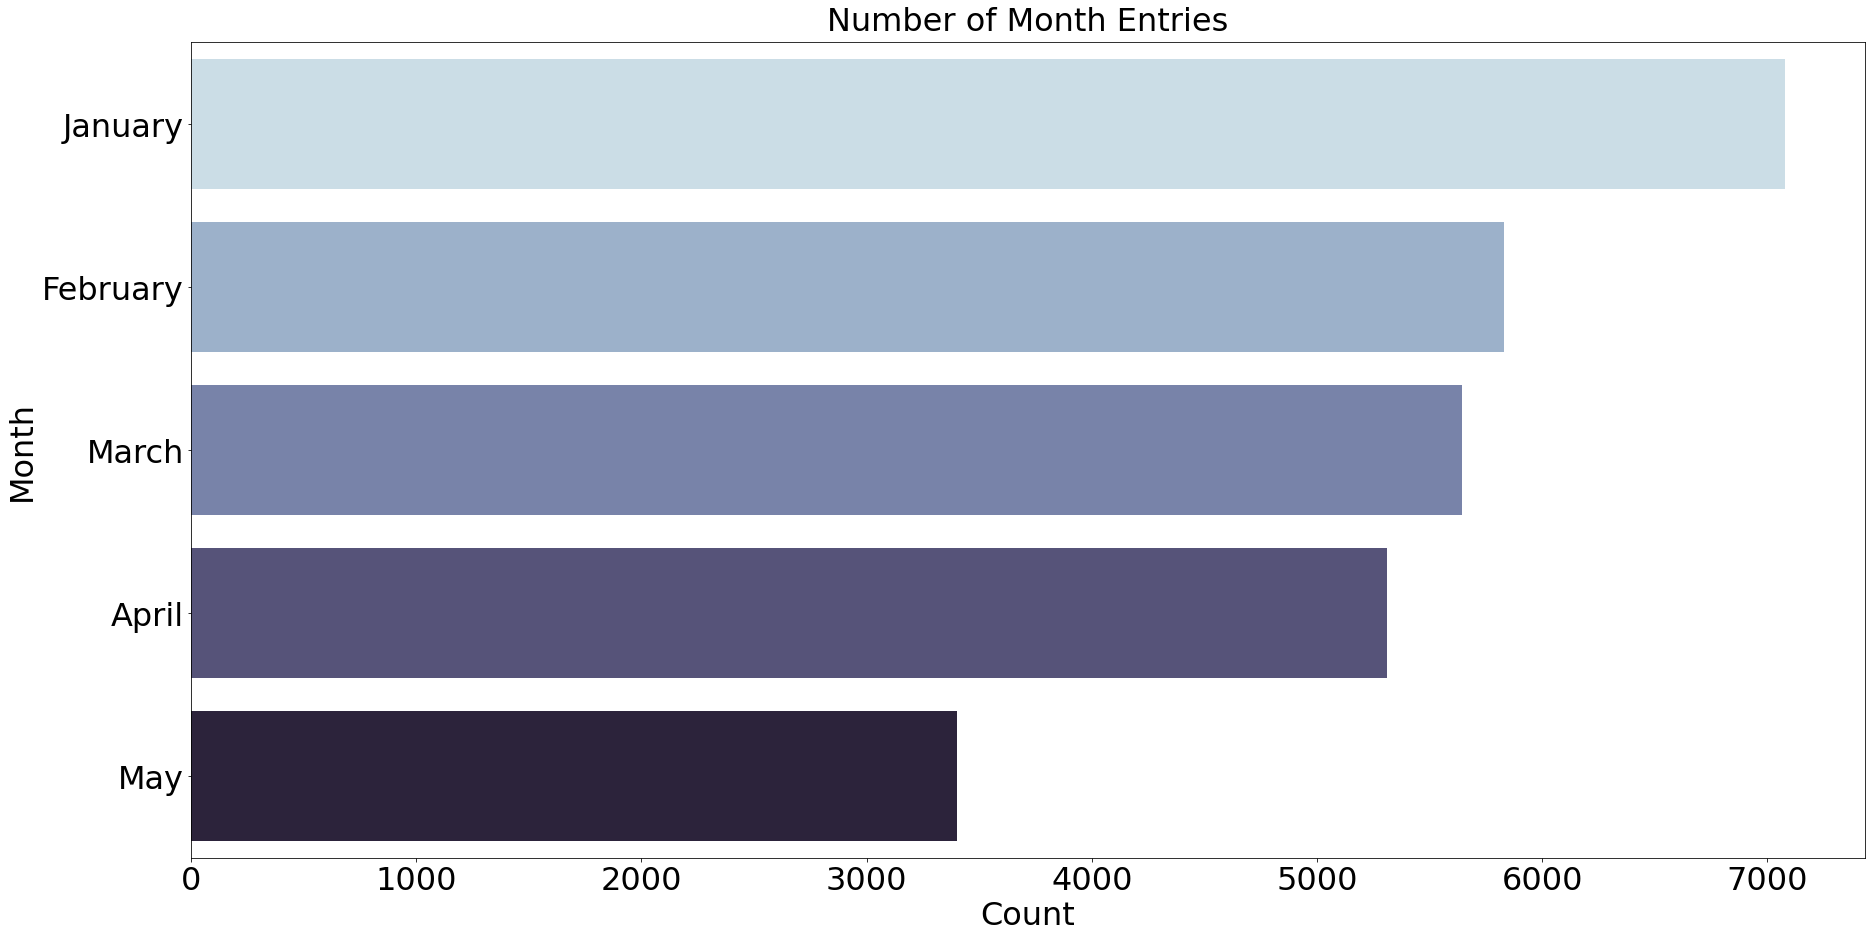

month
April       5312
February    5830
January     7080
March       5642
May         3402
dtype: int64

In [23]:
sns.countplot(y=TrainData_Date['month'], palette='ch:s=.25,rot=-.25').set_title('Number of Month Entries', fontdict={'fontsize':32}, pad=12)

plt.xticks(size=32)
plt.yticks(size=32)

plt.xlabel('Count', fontsize=32)
plt.ylabel('Month', fontsize=32)

plt.show()

TrainData_Date.groupby('month').size()

#### Distribution between Train Number and Hour

In [24]:
TrainData_Date.groupby(['train','hour']).size()

train  hour    
1      06:00:00    577
       07:00:00      3
2      06:00:00    349
       07:00:00    211
3      06:00:00    108
                  ... 
53     07:00:00    237
       08:00:00    183
54     08:00:00    420
55     08:00:00    230
       09:00:00    190
Length: 97, dtype: int64

#### Distribution between Station and Hour

In [25]:
TrainData_Date.groupby(['station','hour']).size()

station  hour    
AA       06:00:00    110
         07:00:00    118
         08:00:00    110
         09:00:00      9
AB       06:00:00    161
                    ... 
BI       09:00:00      2
BJ       06:00:00     59
         07:00:00    115
         08:00:00    116
         09:00:00     57
Length: 123, dtype: int64

## Correlation Matrix

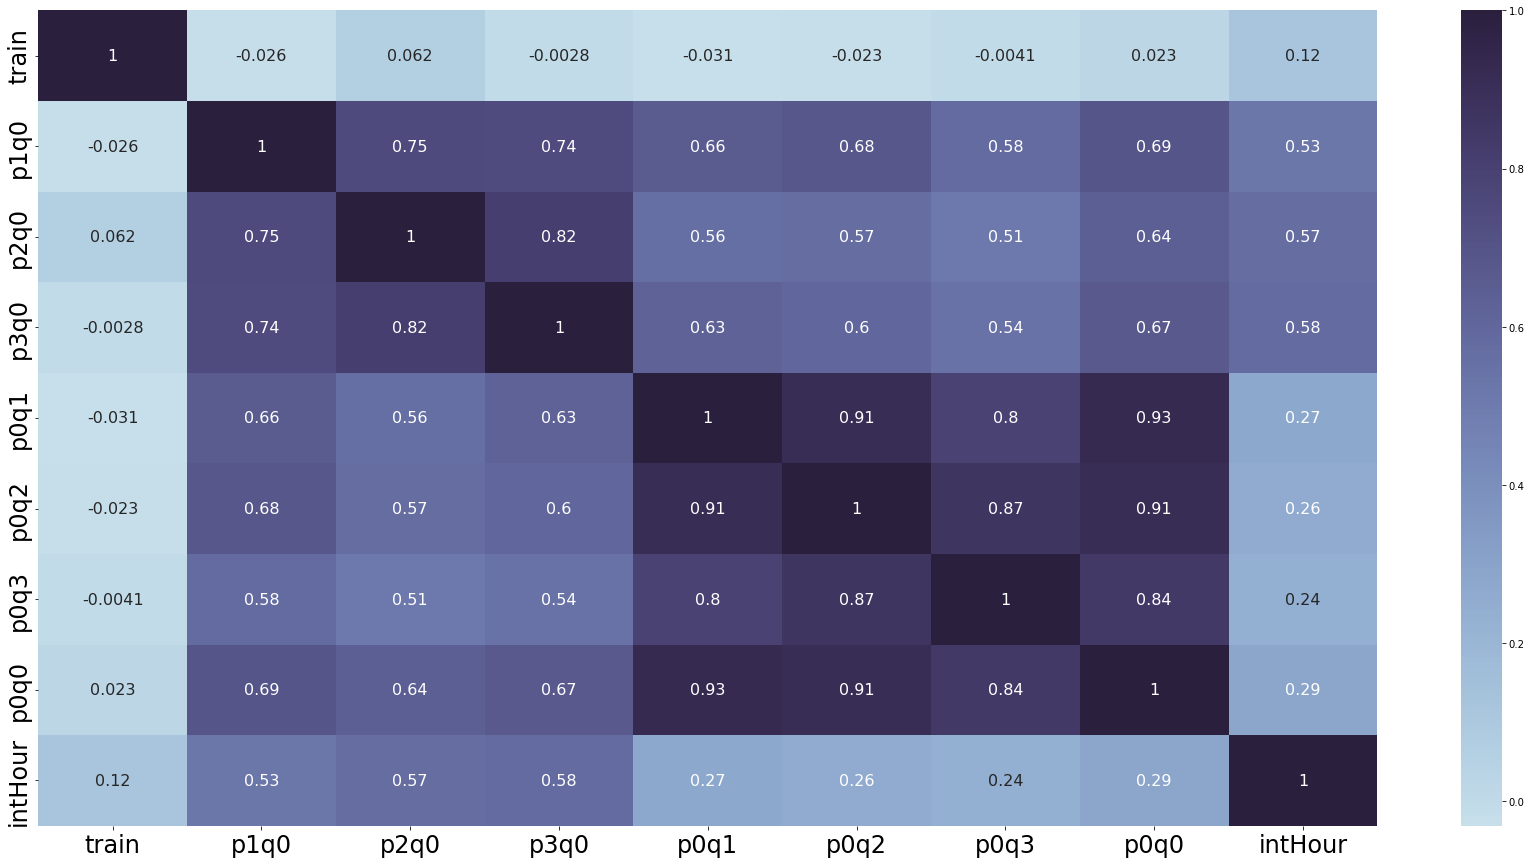

In [28]:
TrainData_Date['hour'] = pd.to_datetime(TrainData_Date['hour'], format='%H:%M:%S')
TrainData_Date['intHour'] = TrainData_Date['hour'].apply(lambda x: int(x.hour))

sns.heatmap(TrainData_Date.corr(),annot=True, annot_kws={"fontsize":16}, cmap=sns.color_palette('ch:s=.25,rot=-.25', as_cmap=True))

plt.xticks(size=24)
plt.yticks(size=24)

plt.show()

# Data Analysis and Machine Learning Models

Baseline Models:

*   Model 1:    using P*q0 (different train - same station)
*   Model 2:    using p0q* (same train - different station)


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

Model 1 -> P*q0 (Different train - same station)

r2 socre is:            0.42    ->  %41.72
Mean Squard Error is:     0.47    ->  %46.8


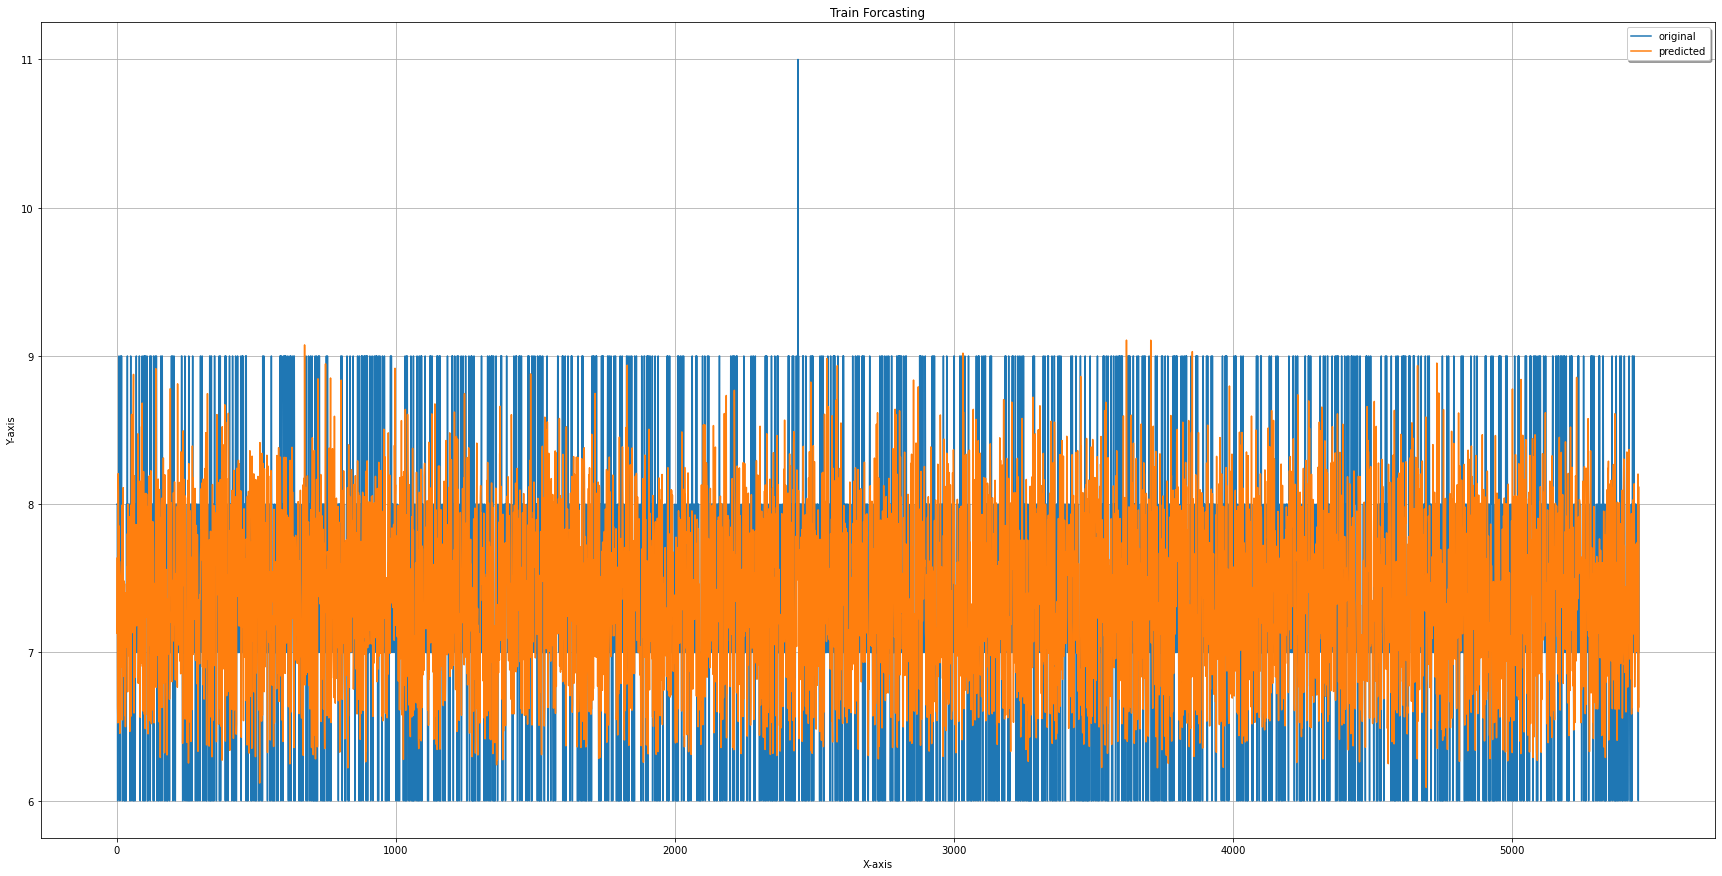

In [30]:
model_1 = TrainData_Date.copy()
columns = ['date','weekday','month','train','station','hour','p0q1','p0q2','p0q3']
model_1 = model_1.drop(columns=columns, axis= 1)
features = model_1.iloc[:,:-1]
target = model_1.iloc[:,-1:]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

LR = LinearRegression()
LR.fit(x_train,y_train)

y_prediction =  LR.predict(x_test)
y_prediction

# Compare Predicted Values with the original values to determine accuracy: scale 0-100 %
score=r2_score(y_test,y_prediction)

mse = mean_squared_error(y_test, y_prediction)
print(f'r2 socre is:            {round(score,2)}    ->  %{round(score*100,2)}')
print(f'Mean Squard Error is:     {round(mse,2)}    ->  %{round(mse*100,2)}')

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_prediction, label="predicted")
plt.title("Train Forcasting")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.rcParams['figure.figsize'] = [30, 15]
plt.show()

Model 2 -> p0Q* (Different Station - same Train)

r2 socre is:            0.09    ->  %8.79
Mean Squard Error is:     0.73    ->  %73.23


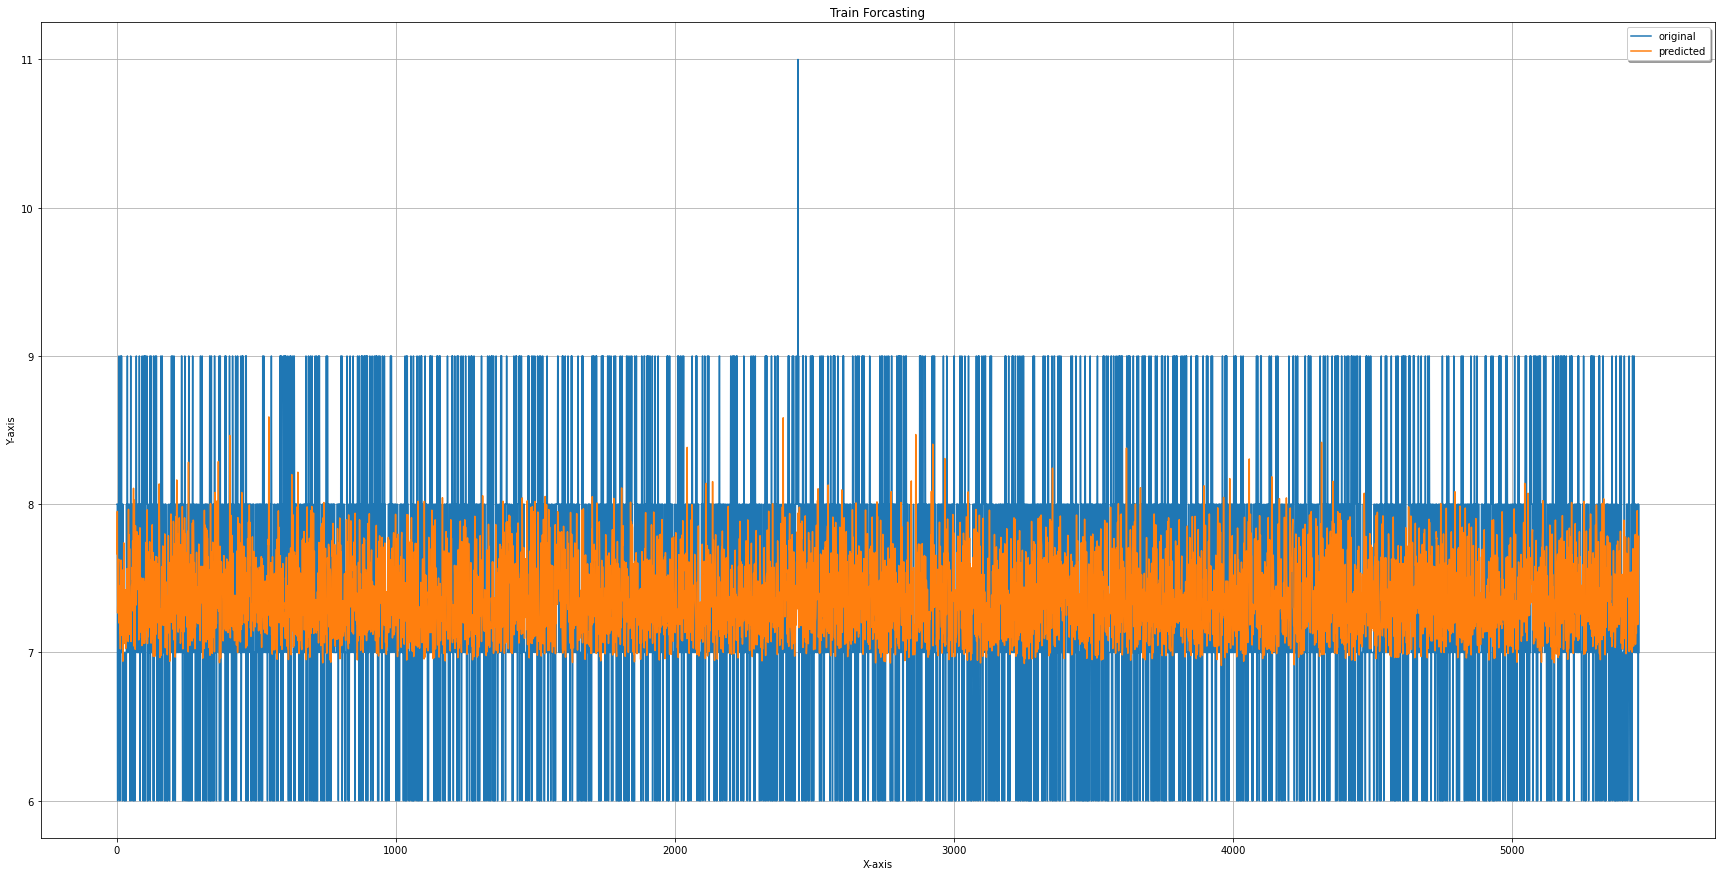

In [31]:
model_2 = TrainData_Date.copy()
columns = ['date','weekday','month','train','station','hour','p1q0','p2q0','p3q0']
model_2 = model_2.drop(columns=columns, axis= 1)
features = model_2.iloc[:,:-1]
target = model_2.iloc[:,-1:]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

LR = LinearRegression()
LR.fit(x_train,y_train)

y_prediction =  LR.predict(x_test)
y_prediction

# Compare Predicted Values with the original values to determine accuracy: scale 0-100 %
score=r2_score(y_test,y_prediction)


mse = mean_squared_error(y_test, y_prediction)

print(f'r2 socre is:            {round(score,2)}    ->  %{round(score*100,2)}')
print(f'Mean Squard Error is:     {round(mse,2)}    ->  %{round(mse*100,2)}')

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_prediction, label="predicted")
plt.title("Train Forcasting")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.rcParams['figure.figsize'] = [30, 15]
plt.show()

r2 socre is:            0.09    ->  %8.71
Mean Squard Error is:     0.73    ->  %73.3


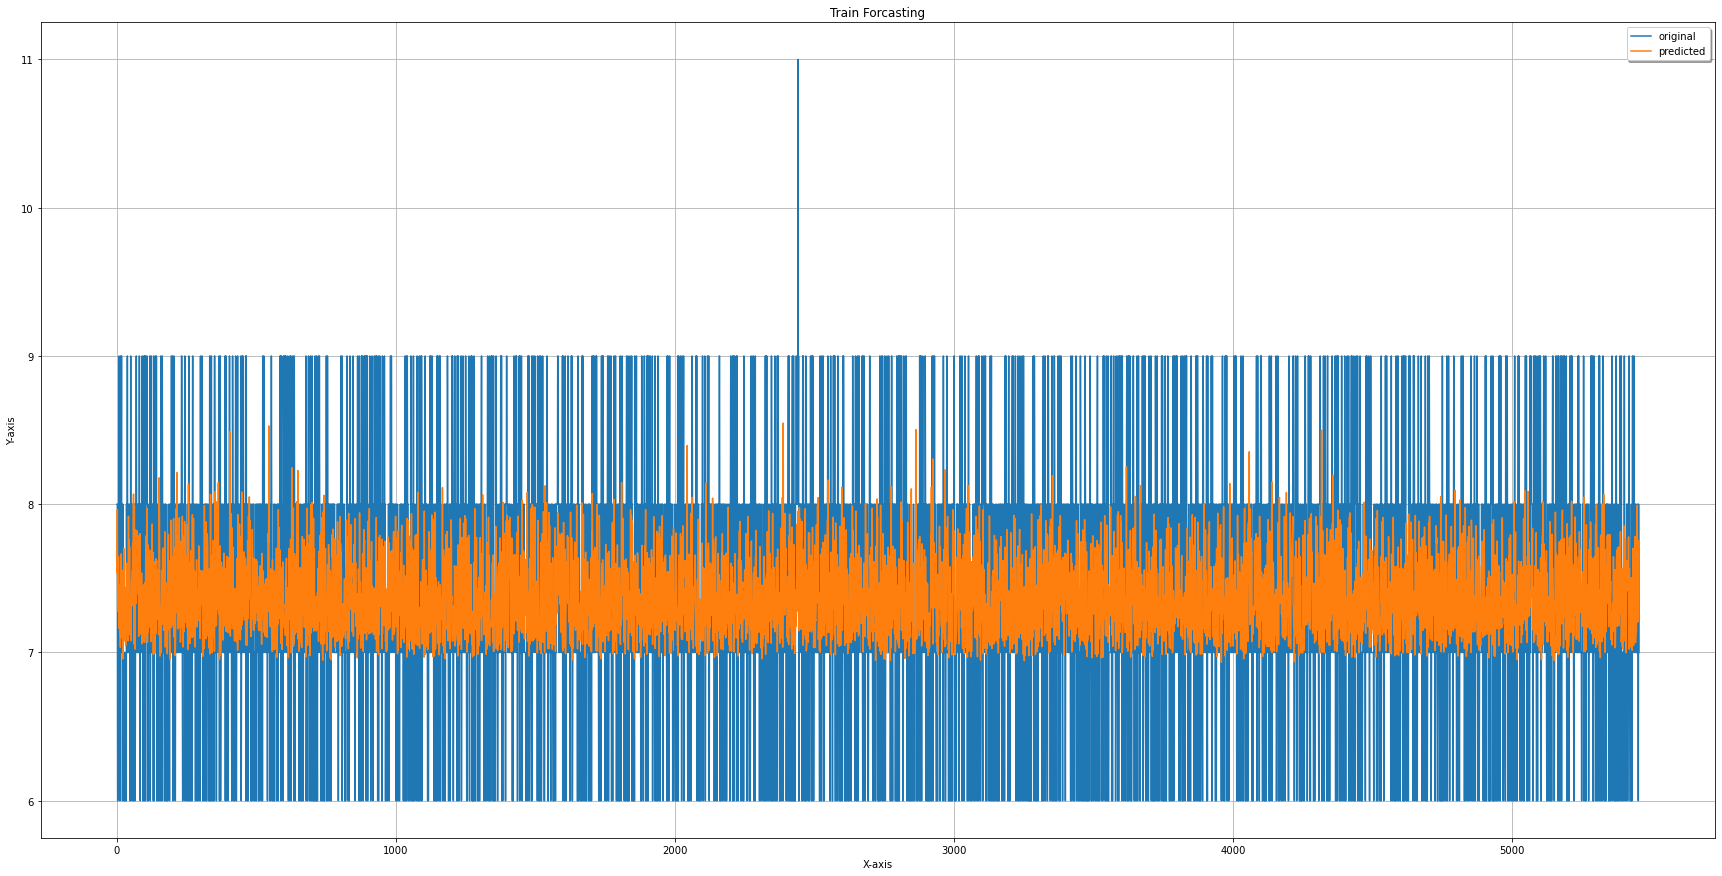

In [32]:
model_3 = TrainData_Date.copy()
columns = ['date','weekday','month','train','station','hour','p1q0','p2q0','p3q0','p0q1','p0q2','p0q3']
model_3 = model_3.drop(columns=columns, axis= 1)
features = model_3.iloc[:,:-1]
target = model_3.iloc[:,-1:]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

LR = LinearRegression()
LR.fit(x_train,y_train)

y_prediction =  LR.predict(x_test)
y_prediction

# Compare Predicted Values with the original values to determine accuracy: scale 0-100 %
score=r2_score(y_test,y_prediction)


mse = mean_squared_error(y_test, y_prediction)

print(f'r2 socre is:            {round(score,2)}    ->  %{round(score*100,2)}')
print(f'Mean Squard Error is:     {round(mse,2)}    ->  %{round(mse*100,2)}')

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_prediction, label="predicted")
plt.title("Train Forcasting")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.rcParams['figure.figsize'] = [30, 15]
plt.show()